# Predicting Abalone Age

Abalones are a rare type of marine snail found in cold coastal saltwater and highly valued for their culinary uses. The common name abalone refers to a number of large gastropod molluscs in the family *Haliotidae*. It’s popularity as a culinary delicacy has caused great pressure on the species due to overharvesting, in turn rendering it even rarer and more expensive. Assessing the age of these organisms, whether for purposes of conservation, harvesting, or research, is a tedious task that requires cutting open the snail’s shell, staining it, and counting the individual rings under a microscope. For this reason, we wish to design a model that will **predict the age of abalones** through other measurements, such as physical dimensions and weight, using regression.

The dataset we will use contains 4,177 observations and 9 columns: sex (either M, F, or I for infant), length in mm, diameter in mm, height in mm, whole weight in grams, shucked weight in grams (without shell), viscera weight in grams (after bleeding), shell weight in grams, and finally number of rings, which is approximately 1.5 less than the age of the snail. After the design of the model, we will evaluate the accuracy of our predictions to answer the question: how well can we predict the age of an abalone snail from its size (length and diameter), sex, and weight (whole, shucked, viscera, and shell)?

## Setup code

In [1]:
library(tidyverse)
library(tidymodels)
download.file('https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data', 'data.csv')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Loading and wrangling data

In [2]:
set.seed(695624153)
abalone <- read_csv('data.csv', col_names = c(
    'sex',
    'length',
    'diameter',
    'height',
    'whole_weight',
    'shucked_weight',
    'viscera_weight',
    'shell_weight',
    'rings'
))

abalone <- abalone %>%
    mutate(sex = as_factor(sex)) %>%
    mutate(age = rings + 1.5)

abalone_split <- initial_split(abalone, prop = 0.75, strata = age)
abalone_training <- training(abalone_split)
abalone_testing <- testing(abalone_split)

Parsed with column specification:
cols(
  sex = col_character(),
  length = col_double(),
  diameter = col_double(),
  height = col_double(),
  whole_weight = col_double(),
  shucked_weight = col_double(),
  viscera_weight = col_double(),
  shell_weight = col_double(),
  rings = col_double()
)



## Summarization

Table 1: The number of each amount of rings present in the dataset (mean = 9.934). This is the variable which we aim to predict.

In [3]:
age_counts <- abalone %>%
    group_by(rings) %>%
    summarize(n = n())
age_counts

`summarise()` ungrouping output (override with `.groups` argument)



rings,n
<dbl>,<int>
1,1
2,1
3,15
4,57
5,115
6,259
7,391
8,568
9,689


Table 2: The mean values of each numerical predictor in the data set.

In [4]:
predictor_means <- abalone %>%
    select(-rings) %>%
    summarize(across(length:shell_weight, mean))
predictor_means

length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.5239921,0.4078813,0.1395164,0.8287422,0.3593675,0.1805936,0.2388309


Table 3: The mean values of each predictor with regards to sex of the abalone. From this table we observe that females are generally slightly larger and heavier than males, and both are larger and heavier than infants.

In [5]:
sex_means <- abalone %>%
    group_by(sex) %>%
    summarize(across(length:shell_weight, mean))
sex_means

`summarise()` ungrouping output (override with `.groups` argument)



sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
M,0.5613907,0.4392866,0.1513809,0.9914594,0.4329460,0.21554450,0.2819692
F,0.5790933,0.4547322,0.1580107,1.0465321,0.4461878,0.23068860,0.3020099
I,0.4277459,0.3264940,0.1079955,0.4313625,0.1910350,0.09201006,0.1281822


## Visualization

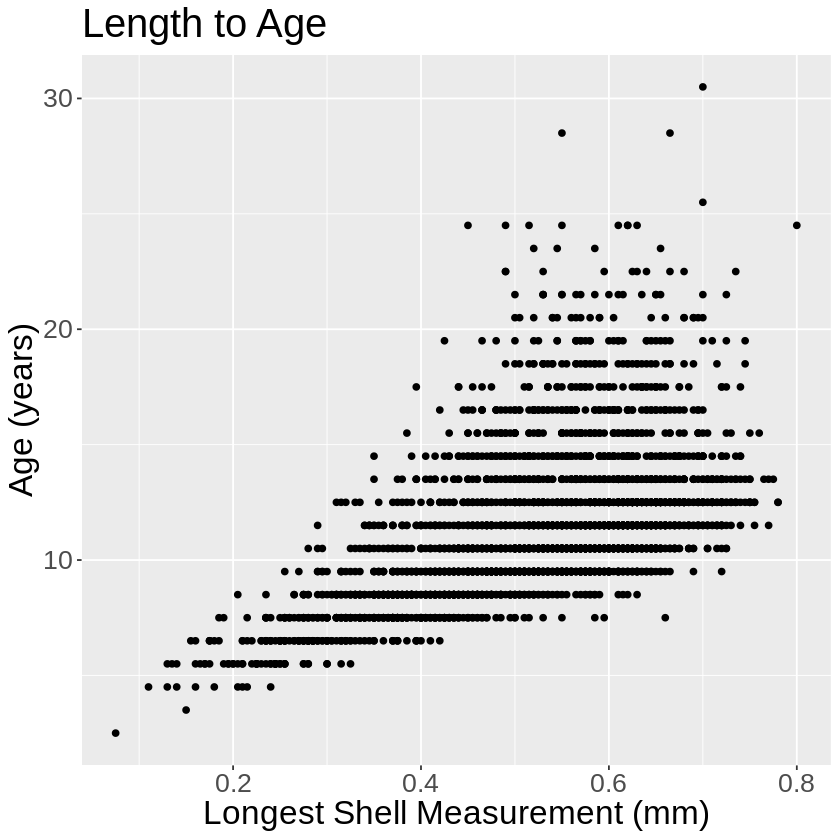

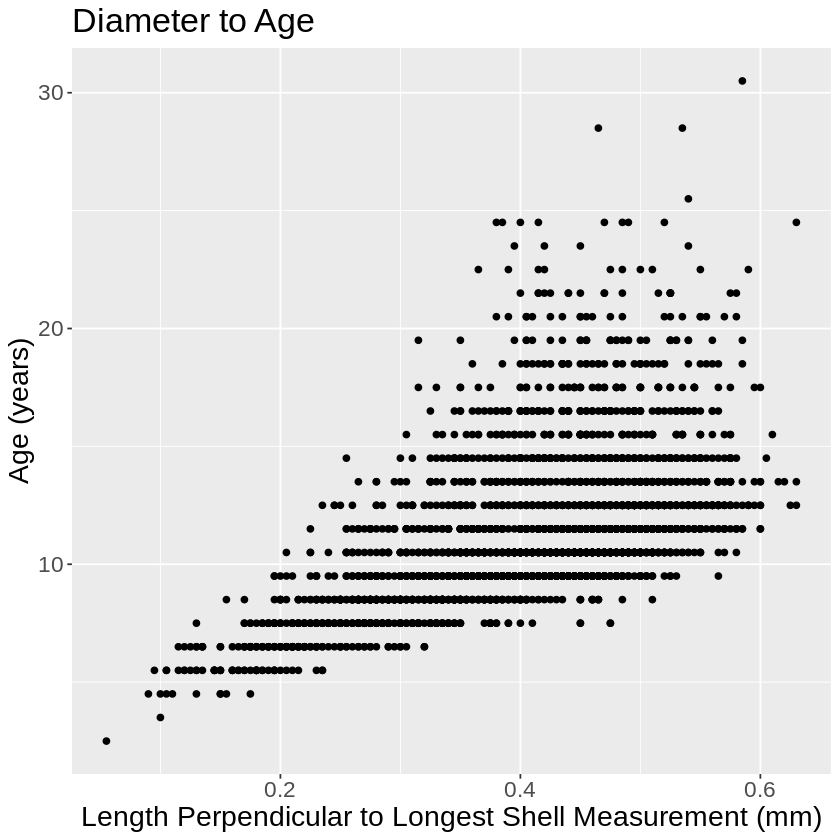

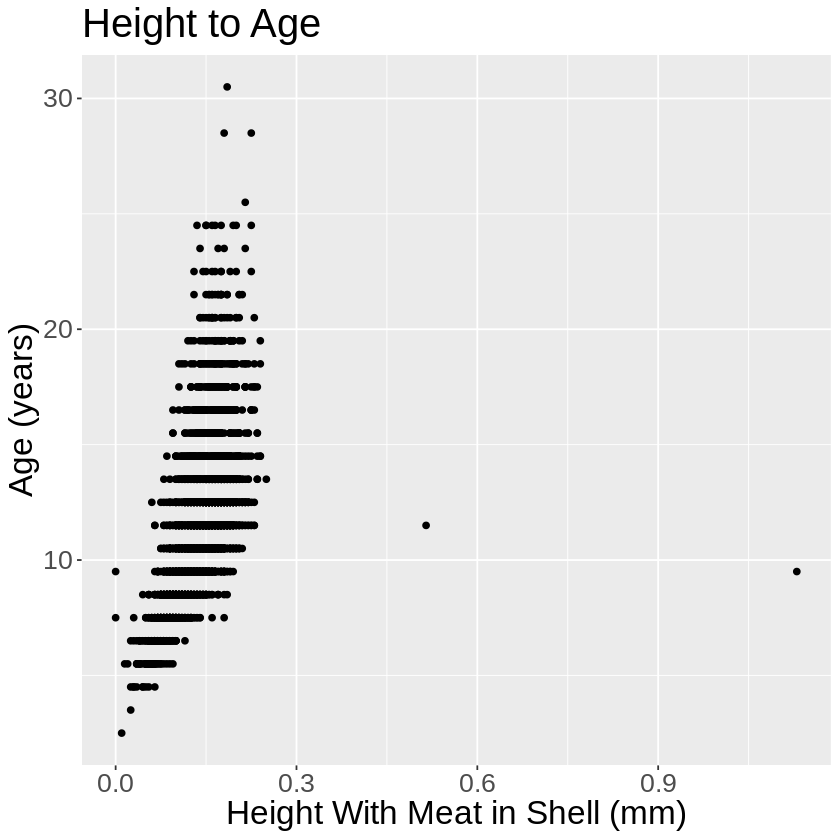

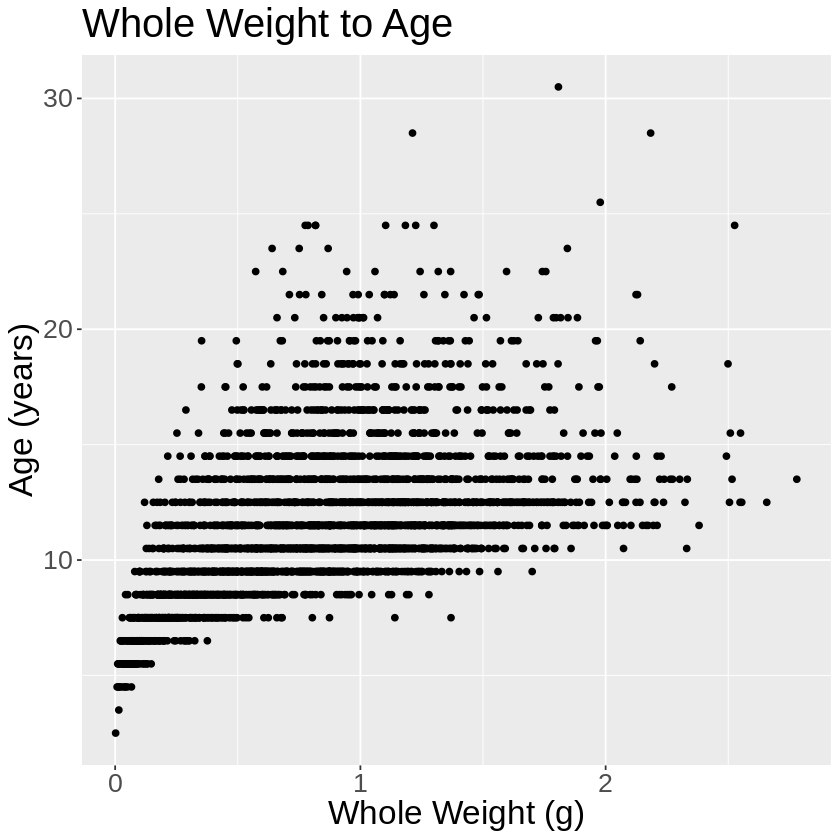

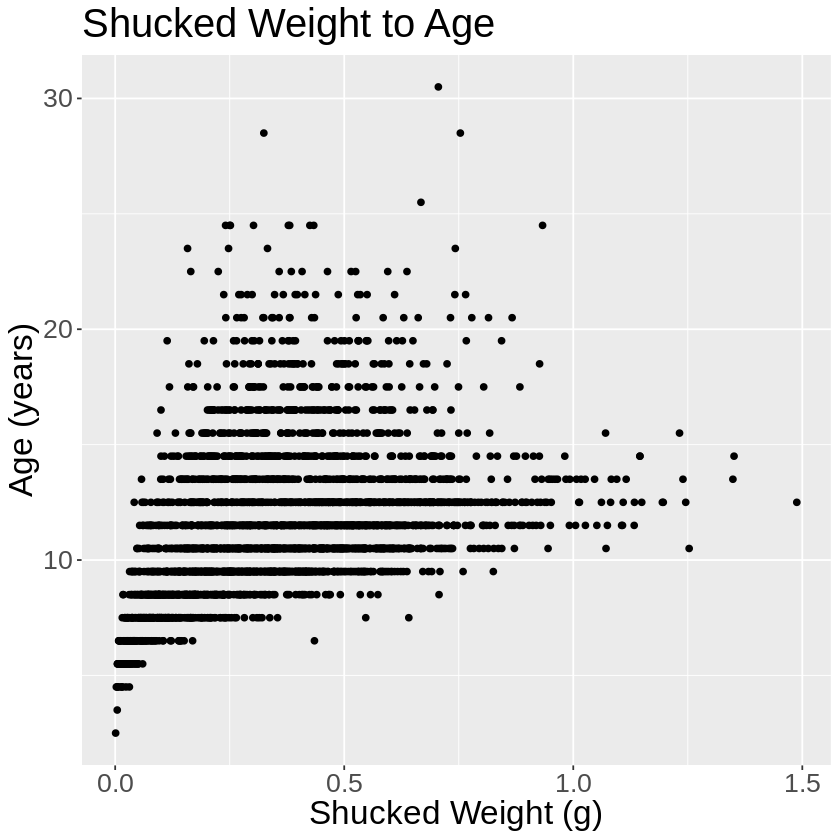

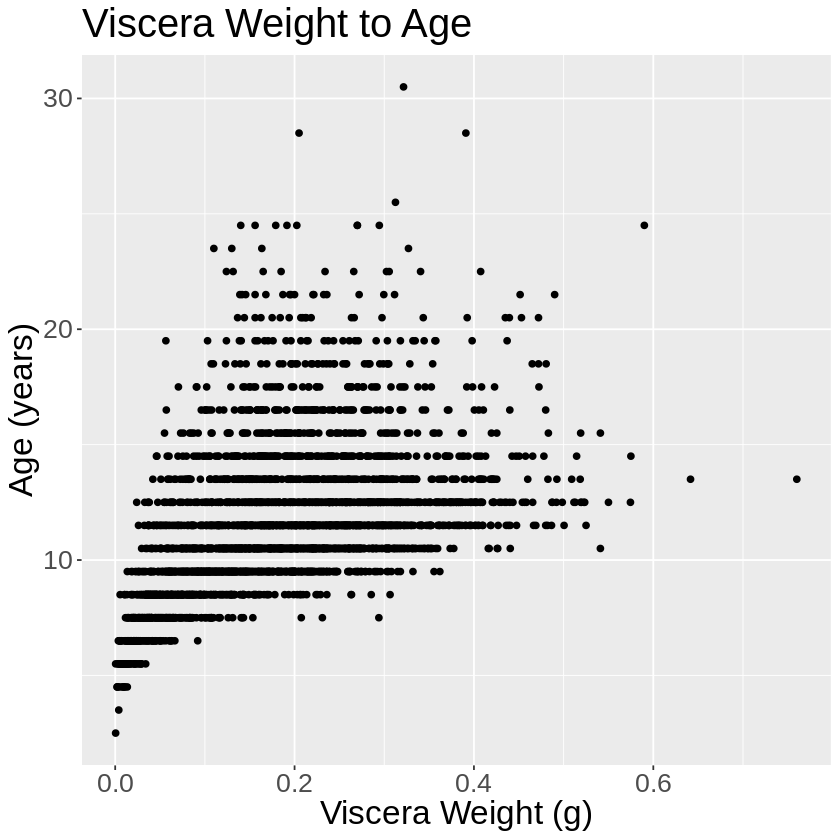

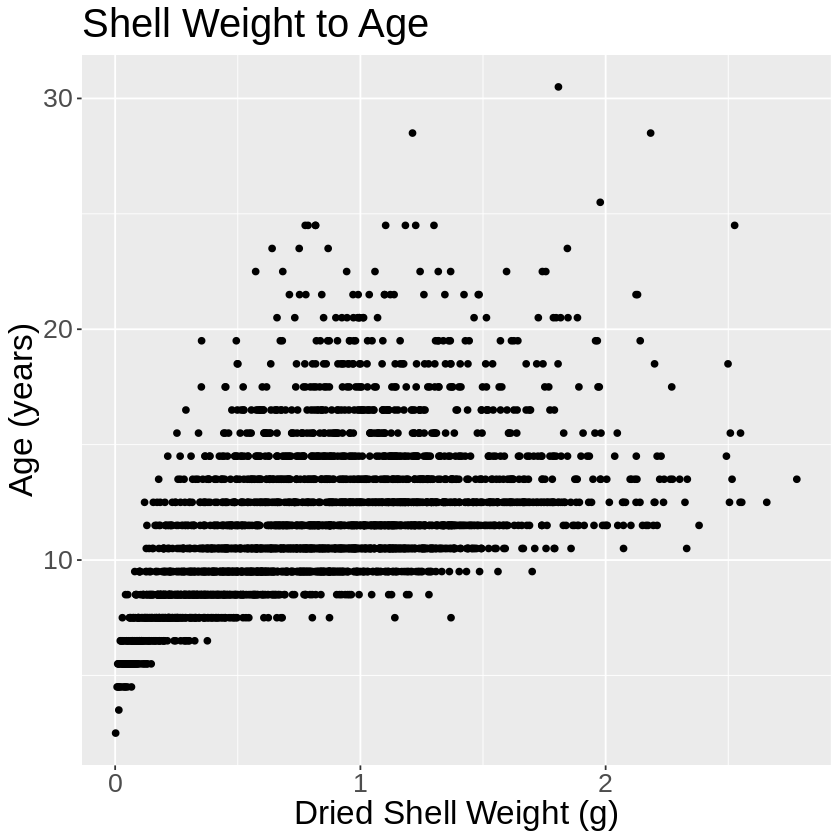

In [6]:
age_length <- abalone_training %>%
ggplot(aes(x = length, y = age)) +
geom_point() +
labs(x = "Longest Shell Measurement (mm)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Length to Age")
age_length

age_diameter <- abalone_training %>%
ggplot(aes(x = diameter, y = age)) +
geom_point() +
labs(x = "Length Perpendicular to Longest Shell Measurement (mm)", y = "Age (years)") +
theme(text = element_text(size = 17)) +
ggtitle("Diameter to Age")
age_diameter

age_height <- abalone_training %>%
ggplot(aes(x = height, y = age)) +
geom_point() +
labs(x = "Height With Meat in Shell (mm)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Height to Age")
age_height

age_whole <- abalone_training %>%
ggplot(aes(x = whole_weight, y = age)) +
geom_point() +
labs(x = "Whole Weight (g)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Whole Weight to Age")
age_whole

age_shucked <- abalone_training %>%
ggplot(aes(x = shucked_weight, y = age)) +
geom_point() +
labs(x = "Shucked Weight (g)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Shucked Weight to Age")
age_shucked

age_viscera <- abalone_training %>%
ggplot(aes(x = viscera_weight, y = age)) +
geom_point() +
labs(x = "Viscera Weight (g)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Viscera Weight to Age")
age_viscera

age_shell <- abalone_training %>%
ggplot(aes(x = whole_weight, y = age)) +
geom_point() +
labs(x = "Dried Shell Weight (g)", y = "Age (years)") +
theme(text = element_text(size = 20)) +
ggtitle("Shell Weight to Age")
age_shell

## Methods

We will use sex, length, diameter, height, and whole weight to predict the age. Sex might influence the other predictors as well as the age, so the model should consider it to counter the effects. Based on the visualization section, the rest appear to have a strong relationship with the age of the abalone, so most of them will be included. However, additional weight measurements beyond the whole weight will not be included because their graphs appear very similar, so it is unlikely that they would be providing any more information and more likely that they would just make the model value weight too much.

Regression will be used as the method of predicting ages of abalones. This is because the age is a quantitative value. The data set's suggested use was classification, likely because age was derived from ring count which can only be an integer, but we believe that regression is more appropriate despite this because in classification, a prediction can only be completely true or completely false, while in regression the size of the error is measurable. This means that a model that produces slightly wrong predictions will be treated as better than a model that produces very wrong predictions, while in classification both models would be treated as equally bad.

The regression method used will be k-nearest-neighbor. This is more appropriate than a linear model because it is possible that abalones might have periods of faster or slower growth rates in their life cycle, such as growing faster when young and growing more slowly when old. A k-nearest-neighbor model can adapt to the changing growth rates, but a linear model cannot. K-nearest-neighbor models are unable to extrapolate when given predictors that are out of the range of the training data, but it is unlikely to occur in real world use because there is a range of possible sizes that an individual of any given species can realistically be, and is therefore unlikely to be a problem.

The sex predictor might be problematic because it is a factor where every possibility is a string, not a number. The training functions might expect numbers and therefore be unable to work with that, but sex cannot meaningfully be converted to a number. If the training functions cannot be made to run using a factor as a predictor, the data will be split into separate sets for male, female, and infant to control for the effects that sex might also have on the predictors.

## Expected Outcomes

We expect to find that older abalone should be larger and heavier than other younger abalone of the same sex as older abalone have more time to grow. The ability to predict the age of an abalone without needing to cut open the shell, stain it, and count the number of rings under a microscope can help scientists save time when performing research on abalone. This will, in theory, allow for more complex and extensive research on the species as collecting essential measurements will be less labor intensive.
